In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
def get_comment(file):
    with open(os.path.join(mydir,file+".txt"), 'r', encoding='utf8') as f:
        return f.read().lower()
    return

In [19]:
mydir = 'C:\\Users\\Sandesh\\Desktop\\hate-speech-dataset\\all_files'
df =pd.read_csv("C:/Users/Sandesh/Desktop/hate-speech-dataset/annotations_metadata.csv")
df['text'] = df['file_id'].apply(lambda x:get_comment(x))

In [20]:
mapping = {'noHate': 1, 'hate':2, 'relation':3,'idk/skip':4 }
df['new_label'] = df['label'].apply(lambda s: mapping.get(s))

In [21]:
df.head()

,file_id,user_id,subforum_id,num_contexts,label,text,new_label
0,12834217_1,572066,1346,0,noHate,"as of march 13th , 2014 , the booklet had been...",1
1,12834217_2,572066,1346,0,noHate,in order to help increase the booklets downloa...,1
2,12834217_3,572066,1346,0,noHate,( simply copy and paste the following text int...,1
3,12834217_4,572066,1346,0,hate,click below for a free download of a colorfull...,2
4,12834217_5,572066,1346,0,noHate,click on the `` download ( 7.42 mb ) '' green ...,1


In [26]:
df.to_csv("raw.csv")

[Text(0.5, 0, 'Labels')]

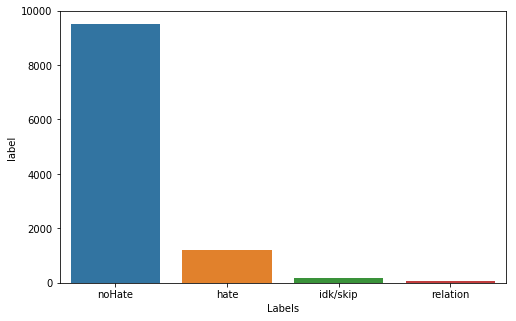

In [30]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# use pathlib to load path
data_root = pathlib.Path('./')
df = pd.read_csv(data_root/'raw.csv', error_bad_lines=False)

fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.label.unique(),y=df.label.value_counts());
ax.set(xlabel='Labels')

build the vocab of all unique words in lowercase

Progress: 100%|██████████████████████████████████████████████████████████████| 10944/10944 [00:00<00:00, 238166.08it/s]


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Tweet Length')]

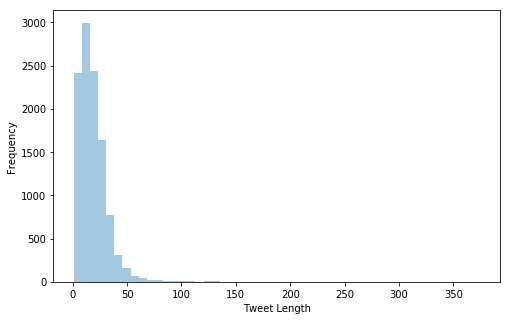

In [23]:
# build the vocab of all unique words in lowercase
from collections import Counter
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

# load spacy tokenizer
nlp = spacy.load('en',disable=['parser', 'tagger', 'ner'])
# df.progress_apply is tqdm method for pandas. It shows progress bar for apply function
# remove the leading and trailing spaces
df['text'] = df.text.progress_apply(lambda x: x.strip())

# build vocabulary and corresponding counts
words = Counter()
for sent in tqdm(df.text.values):
    words.update(w.text.lower() for w in nlp(sent))
   
# sort with most frequently occuring words first
words = sorted(words, key=words.get, reverse=True)
# add <pad> and <unk> token to vocab which will be used later
words = ['_PAD','_UNK'] + words

# create word to index dictionary and reverse
word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

def indexer(s): 
    return [word2idx[w.text.lower()] for w in nlp(s)]

# tokenize the tweets and calculate lengths
df['textidx'] = df.text.progress_apply(indexer)
df['lengths'] = df.textidx.progress_apply(len)

fig = plt.figure(figsize=(8,5))
ax = sns.distplot(df.lengths.values,kde=False);
ax.set(xlabel='Tweet Length', ylabel='Frequency')


In [24]:
df.head()

,file_id,user_id,subforum_id,num_contexts,label,text,new_label,textidx,lengths
0,12834217_1,572066,1346,0,noHate,"as of march 13th , 2014 , the booklet had been...",1,"[35, 9, 520, 3992, 4, 1452, 4, 3, 1838, 94, 88...",18
1,12834217_2,572066,1346,0,noHate,in order to help increase the booklets downloa...,1,"[10, 703, 6, 321, 3994, 3, 5088, 2456, 4, 12, ...",36
2,12834217_3,572066,1346,0,noHate,( simply copy and paste the following text int...,1,"[56, 806, 1292, 7, 3288, 3, 1069, 965, 130, 50...",16
3,12834217_4,572066,1346,0,hate,click below for a free download of a colorfull...,2,"[632, 832, 16, 8, 222, 807, 9, 8, 5089, 5090, ...",26
4,12834217_5,572066,1346,0,noHate,click on the `` download ( 7.42 mb ) '' green ...,1,"[632, 19, 3, 26, 26, 807, 56, 7377, 3997, 54, ...",15


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

# subclass the custom dataset class with torch.utils.data.Dataset
# implement __len__ and __getitem__ function
class VectorizeData(Dataset):
    def __init__(self, df_path):
        self.df = pd.read_csv(df_path, error_bad_lines=False)
        self.df['SentimentText'] = self.df.text.progress_apply(lambda x: x.strip())
        self.df['sentimentidx'] = self.df.text.progress_apply(indexer)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.sentimentidx[idx]
        y = self.df.new_label[idx]
        return X,y
      
# create instance of custom dataset
ds = VectorizeData('raw.csv')
# get first 4 samples
print(ds[:4])

Progress: 100%|████████████████████████████████████████████████████████████████| 10944/10944 [00:05<00:00, 2171.39it/s]


(0    [35, 9, 520, 3992, 4, 1452, 4, 3, 1838, 94, 88...
1    [10, 703, 6, 321, 3994, 3, 5088, 2456, 4, 12, ...
2    [56, 806, 1292, 7, 3288, 3, 1069, 965, 130, 50...
3    [632, 832, 16, 8, 222, 807, 9, 8, 5089, 5090, ...
Name: sentimentidx, dtype: object, 0    1
1    1
2    1
3    2
Name: new_label, dtype: int64)


In [29]:
df.head()

,file_id,user_id,subforum_id,num_contexts,label,text,new_label,textidx,lengths
0,12834217_1,572066,1346,0,noHate,"as of march 13th , 2014 , the booklet had been...",1,"[35, 9, 520, 3992, 4, 1452, 4, 3, 1838, 94, 88...",18
1,12834217_2,572066,1346,0,noHate,in order to help increase the booklets downloa...,1,"[10, 703, 6, 321, 3994, 3, 5088, 2456, 4, 12, ...",36
2,12834217_3,572066,1346,0,noHate,( simply copy and paste the following text int...,1,"[56, 806, 1292, 7, 3288, 3, 1069, 965, 130, 50...",16
3,12834217_4,572066,1346,0,hate,click below for a free download of a colorfull...,2,"[632, 832, 16, 8, 222, 807, 9, 8, 5089, 5090, ...",26
4,12834217_5,572066,1346,0,noHate,click on the `` download ( 7.42 mb ) '' green ...,1,"[632, 19, 3, 26, 26, 807, 56, 7377, 3997, 54, ...",15


In [31]:
dl = DataLoader(dataset=ds, batch_size=3) 
print('Total samples', len(dl))
# Total batches 526204

it = iter(dl)
xs,ys = next(it)
print('Length of smallest tweet', len(xs))
print(type(xs))
print(xs)

Total samples 3648
Length of smallest tweet 16
<class 'list'>
[tensor([35, 10, 56]), tensor([  9, 703, 806]), tensor([ 520,    6, 1292]), tensor([3992,  321,    7]), tensor([   4, 3994, 3288]), tensor([1452,    3,    3]), tensor([   4, 5088, 1069]), tensor([   3, 2456,  965]), tensor([1838,    4,  130]), tensor([94, 12, 50]), tensor([88, 61, 67]), tensor([2455,   32,  460]), tensor([ 129,  142, 2017]), tensor([5087,   39, 3286]), tensor([210,  31,   2]), tensor([   7, 3995,   54])]


In [38]:
class VectorizeData(Dataset):
    def __init__(self, df_path, maxlen=10):
        self.maxlen = maxlen
        self.df = pd.read_csv(df_path, error_bad_lines=False)
        self.df['text'] = self.df.text.apply(lambda x: x.strip())
        print('Indexing...')
        self.df['sentimentidx'] = self.df.text.progress_apply(indexer)
        print('Calculating lengths')
        self.df['lengths'] = self.df.sentimentidx.progress_apply(lambda x: self.maxlen if len(x) > self.maxlen else len(x))
        print('Padding')
        self.df['sentimentpadded'] = self.df.sentimentidx.progress_apply(self.pad_data)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.sentimentpadded[idx]
        lens = self.df.lengths[idx]
        y = self.df.label[idx]
        return X,y,lens
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded
      
ds = VectorizeData(data_root/'raw.csv')
print(ds[:5])

Indexing...



Progress: 100%|████████████████████████████████████████████████████████████████| 10944/10944 [00:05<00:00, 2098.37it/s]


Calculating lengths



Progress: 100%|██████████████████████████████████████████████████████████████| 10944/10944 [00:00<00:00, 165918.91it/s]


Padding



Progress: 100%|███████████████████████████████████████████████████████████████| 10944/10944 [00:00<00:00, 59192.09it/s]


(0        [35, 9, 520, 3992, 4, 1452, 4, 3, 1838, 94]
1      [10, 703, 6, 321, 3994, 3, 5088, 2456, 4, 12]
2    [56, 806, 1292, 7, 3288, 3, 1069, 965, 130, 50]
3      [632, 832, 16, 8, 222, 807, 9, 8, 5089, 5090]
4      [632, 19, 3, 26, 26, 807, 56, 7377, 3997, 54]
Name: sentimentpadded, dtype: object, 0    noHate
1    noHate
2    noHate
3      hate
4    noHate
Name: label, dtype: object, 0    10
1    10
2    10
3    10
4    10
Name: lengths, dtype: int64)


In [39]:
dl = DataLoader(dataset=ds, batch_size=3)
print(len(dl))

3648


In [40]:
it = iter(dl)
xs,ys,lens =  next(it)
print(type(xs))
print(xs)

<class 'torch.Tensor'>
tensor([[  35,    9,  520, 3992,    4, 1452,    4,    3, 1838,   94],
        [  10,  703,    6,  321, 3994,    3, 5088, 2456,    4,   12],
        [  56,  806, 1292,    7, 3288,    3, 1069,  965,  130,   50]])


In [45]:
words

['_PAD',
 '_UNK',
 '.',
 'the',
 ',',
 'i',
 'to',
 'and',
 'a',
 'of',
 'in',
 'is',
 'it',
 'that',
 'you',
 '-',
 'for',
 'are',
 'have',
 'on',
 'they',
 '?',
 'this',
 'white',
 '!',
 "'s",
 '`',
 'with',
 'was',
 'my',
 'do',
 'all',
 'be',
 'not',
 'but',
 'as',
 'like',
 'we',
 'or',
 'if',
 'there',
 "n't",
 'their',
 ':',
 'just',
 "'",
 'at',
 'will',
 'from',
 'so',
 'your',
 'out',
 'people',
 'them',
 ')',
 'about',
 '(',
 'can',
 'me',
 'up',
 '...',
 'would',
 'one',
 "''",
 'get',
 '*',
 'who',
 'youtube',
 'here',
 'what',
 'when',
 'by',
 '/',
 'no',
 'our',
 'some',
 'black',
 'more',
 'an',
 'see',
 'good',
 'm',
 'he',
 'has',
 'whites',
 'know',
 'how',
 'go',
 'been',
 'other',
 'time',
 'nt',
 'think',
 'were',
 'had',
 'then',
 'only',
 'her',
 'new',
 'school',
 'these',
 'should',
 'back',
 'any',
 'want',
 'because',
 'say',
 'than',
 'few',
 'well',
 'those',
 'us',
 'now',
 'race',
 'many',
 'too',
 'old',
 'day',
 'very',
 'his',
 'way',
 'got',
 'kids',

In [57]:
NGRAMS = 2
import os
if not os.path.isdir('./.data'):
    os.mkdir('./.data')
train_dataset, test_dataset = text_classification(
    root='./.data', ngrams=NGRAMS, vocab=None)
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


AttributeError: module 'torchtext.datasets.text_classification' has no attribute 'ds'

In [44]:
import torch.nn as nn
import torch.nn.functional as F
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [49]:
VOCAB_SIZE = len(words)
EMBED_DIM = 32
NUN_CLASS = len(df.label)
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

In [50]:
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [51]:
from torch.utils.data import DataLoader

def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text, offsets, cls in data:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

In [60]:
import time
from torch.utils.data.dataset import random_split
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(ds) * 0.95)
sub_train_, sub_valid_ = \
    random_split(ds, [train_len, len(ds) - train_len])

for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')


KeyError: tensor(6839)